# Comparing 2DTM scoring metrics

This notebook demonstrates how the three scoring metrics implemented in Leopard-EM work by visualizing the steps along each process.
Data used in this notebook are hosted on [Zenodo](https://zenodo.org/records/15426374).

In [1]:
"""2DTM scoring metrics."""

import matplotlib as mpl
import matplotlib.pyplot as plt
import mrcfile
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from leopard_em.analysis.gev_fit_metric import fit_gev_to_zscore
from leopard_em.analysis.pvalue_metric import (
    _params_to_multivariate_normal,
    fit_full_cov_gaussian_2d,
    probit_transform,
)
from leopard_em.analysis.zscore_metric import gaussian_noise_zscore_cutoff

plt.rcParams["figure.dpi"] = 120  # Increase resolution of plots

### Downloading Example Data

Run the following code cell to download the results into the current directory of the notebook.
Otherwise, place the downloaded data in the same directory as the notebook or adjust the paths in the following cell(s).

In [2]:
import requests


def download_zenodo_file(url: str) -> str:
    """Downloads a zenodo file from the given URL. Returns the output filename."""
    output_filename = url.split("/")[-1]

    response = requests.get(url, stream=True)
    response.raise_for_status()  # Check for request errors

    with open(output_filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    return output_filename


# NOTE: This may take a few seconds to few minutes, depending on internet connection
file_urls = [
    "https://zenodo.org/records/15426374/files/xenon_216_000_0_output_mip.mrc",
    "https://zenodo.org/records/15426374/files/xenon_216_000_0_output_scaled_mip.mrc",
]

for url in file_urls:
    filename = download_zenodo_file(url)
    print(f"Downloaded {filename}")

Downloaded xenon_216_000_0_output_mip.mrc
Downloaded xenon_216_000_0_output_scaled_mip.mrc


### Load data into memory

Using the `mrcfile` package to read each of the downloaded example files into a numpy array

In [3]:
mip = mrcfile.open("xenon_216_000_0_output_mip.mrc", mode="r").data.copy()
scaled_mip = mrcfile.open("xenon_216_000_0_output_scaled_mip.mrc", mode="r").data.copy()

### Known parameters from 2DTM search

Manually setting the number of orientations and defocus planes searched.

In [4]:
num_orientations = 1584480
num_defocus = 13
total_correlations = num_orientations * num_defocus

## *A Priori* z-score cutoff

The distribution of cross-correlation values in 2DTM follows a standard normal distribution when the image contains only noise (no macromolecule of interest).
Using the normal distribution assumption, we can construct the probability that a given maximum cross-correlation value corresponds to true signal rather than background noise.
And by setting a value cutoff to *n* false-positive per image, we derive the ***A Priori* z-score cutoff**.

The *a priori* z-score cutoff depends on the size of the 2DTM search space, number of pixels in the searched image, and desired number of false-positives.

In [5]:
# Calculating our z-score cutoff
apr_zscore_cutoff = gaussian_noise_zscore_cutoff(
    total_correlations * mip.size, false_positives=1.0
)
print(f"A priori z-score cutoff: {apr_zscore_cutoff:.3f}")

A priori z-score cutoff: 7.775


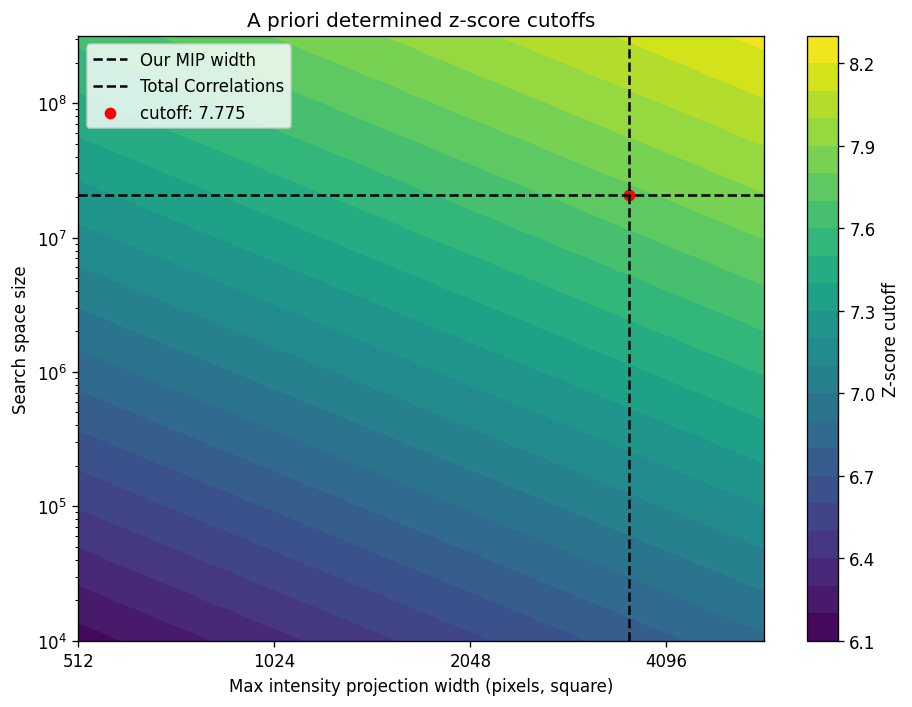

In [6]:
# Create grid of number of pixels and search space size
x = np.logspace(9, 12.5, num=32, base=2)  # Image width
y = np.logspace(4, 8.5, num=32, base=10)  # Search space size
xx, yy = np.meshgrid(x, y)

# Calculate z-score cutoff for each pixel
zscore_cutoffs = np.zeros_like(xx)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        num_pixels = int(xx[i, j] ** 2)
        search_space_size = int(yy[i, j])
        zscore_cutoffs[i, j] = gaussian_noise_zscore_cutoff(
            num_ccg=num_pixels * search_space_size,
            false_positives=1.0,
        )

# Contour plot of z-score cutoff
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, zscore_cutoffs, levels=20, cmap="viridis")
plt.colorbar(label="Z-score cutoff")

# Lines corresponding to the results we are investigating
plt.axvline(x=mip.size**0.5, color="k", linestyle="--", label="Our MIP width")
plt.axhline(y=total_correlations, color="k", linestyle="--", label="Total Correlations")
plt.scatter(
    mip.size**0.5,
    total_correlations,
    color="red",
    marker="o",
    label=f"cutoff: {apr_zscore_cutoff:.3f}",
)

plt.xscale("log", base=2)
plt.xticks(
    ticks=[2**i for i in range(9, 13)],
    labels=[f"{int(2**i)}" for i in range(9, 13)],
)
plt.yscale("log", base=10)
plt.xlabel("Max intensity projection width (pixels, square)")
plt.ylabel("Search space size")
plt.title("A priori determined z-score cutoffs")
plt.legend()
plt.tight_layout()
plt.show()

## Fitted extreme value distribution

Since 2DTM records the maximum cross-correlation value over a large search space, the background noise is distributed as a generalized extreme value distribution.
We can fit our data to this distribution to capture slight deviations from idealized normal noise.
Like before, a cutoff value can be derived for a given number of false positives.

In [7]:
# Fit a generalized extreme value (GEV) distribution to the z-scores
# NOTE: this could take a while to run (1-3 mins), depending on the number of samples
gev_opt, (shape, loc, scale) = fit_gev_to_zscore(
    scaled_mip,
    num_samples=1_000_000,
    max_zscore_value=8.5,  # Prevent fitting to signal
)

In [ ]:
gev_zscore_cutoff_val = gev_opt.isf(1 / mip.size)
print(f"GEV z-score cutoff: {gev_zscore_cutoff_val:.3f}")

GEV z-score cutoff: 7.749


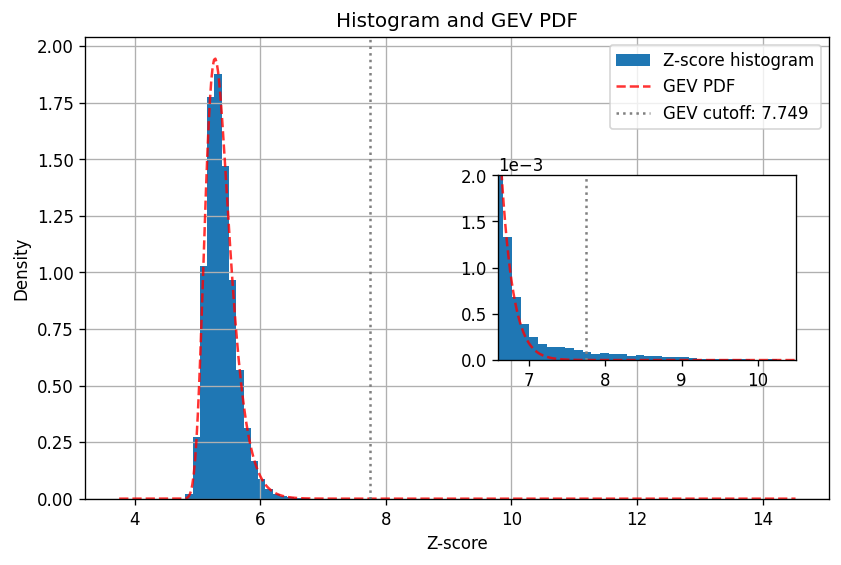

In [ ]:
# Create the main figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the full histogram and fitted GEV PDF on the main axis
counts, bins, _ = ax.hist(
    scaled_mip.ravel(),
    bins=64,
    density=True,
    label="Z-score histogram",
)
x_vals = np.linspace(scaled_mip.min() * 0.8, scaled_mip.max() * 1.2, 500)
ax.plot(
    x_vals,
    gev_opt.pdf(x_vals),
    color="red",
    label="GEV PDF",
    linestyle="--",
    alpha=0.8,
)
ax.axvline(
    gev_zscore_cutoff_val,
    color="grey",
    linestyle=":",
    label=f"GEV cutoff: {gev_zscore_cutoff_val:.3f}",
)
ax.set_title("Histogram and GEV PDF")
ax.set_xlabel("Z-score")
ax.set_ylabel("Density")
ax.grid()

# Create an inset axis in the upper right corner (zoomed view)
axins = inset_axes(ax, width="40%", height="40%", loc="center right", borderpad=2)

axins.hist(scaled_mip.ravel(), bins=64, density=True)
axins.plot(x_vals, gev_opt.pdf(x_vals), color="red", linestyle="--", alpha=0.8)
axins.axvline(gev_zscore_cutoff_val, color="grey", linestyle=":")
axins.set_xlim(6.6, 10.5)
axins.set_ylim(0, 2e-3)  # Adjust y-limit as needed
axins.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax.legend(loc="upper right")
plt.show()

## Using the p-value metric

The p-value metric, described in ((CITE)), fits a 2D Gaussian random variable to the probit transformed MIP and z-score map.
Each pair of MIP and z-scores can then be transformed into a probability value given this fitted 2D Gaussian.
Below, we step through this process but the Leopard-EM package performs all these steps automatically when given the MIP and z-score maps.

### Applying the probit transformation

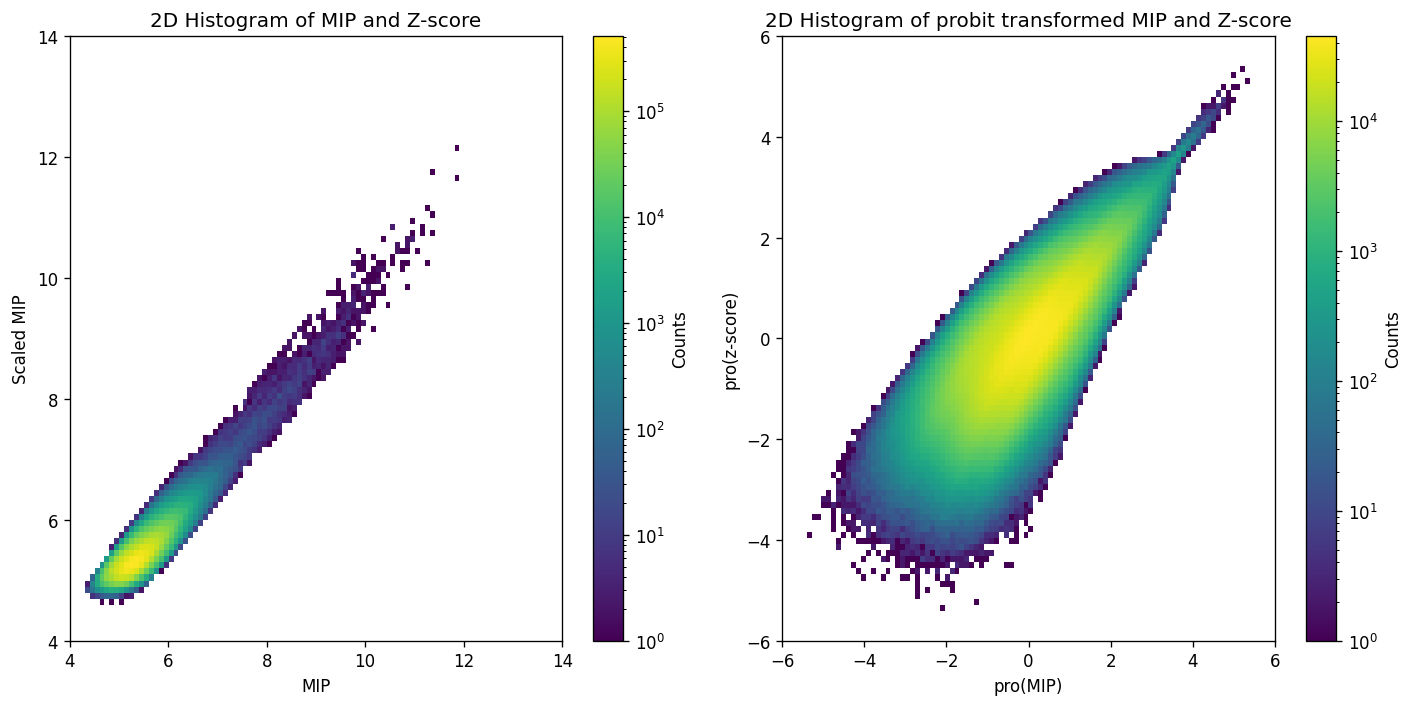

In [10]:
mip_flat = mip.ravel()
scaled_mip_flat = scaled_mip.ravel()

# 2D histogram of the flattened MIP and z-scores
hist, xedges, yedges = np.histogram2d(
    mip_flat,
    scaled_mip_flat,
    bins=100,
    range=[(4, 14), (4, 14)],
)

# Apply a probit transform and recalculate the histogram
mip_probit = probit_transform(mip_flat)
scaled_mip_probit = probit_transform(scaled_mip_flat)

hist_probit, xedges_probit, yedges_probit = np.histogram2d(
    mip_probit,
    scaled_mip_probit,
    bins=100,
    range=[(-6, 6), (-6, 6)],
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original histogram
c1 = ax[0].imshow(
    hist.T,
    origin="lower",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect="auto",
    cmap="viridis",
    norm=mpl.colors.LogNorm(),
)
cbar1 = fig.colorbar(c1, ax=ax[0])
cbar1.set_label("Counts")
ax[0].set_title("2D Histogram of MIP and Z-score")
ax[0].set_xlabel("MIP")
ax[0].set_ylabel("Scaled MIP")

# Plot the probit-transformed histogram
c2 = ax[1].imshow(
    hist_probit.T,
    origin="lower",
    extent=[xedges_probit[0], xedges_probit[-1], yedges_probit[0], yedges_probit[-1]],
    aspect="auto",
    cmap="viridis",
    norm=mpl.colors.LogNorm(),
)
cbar2 = fig.colorbar(c2, ax=ax[1])
cbar2.set_label("Counts")
ax[1].set_title("2D Histogram of probit transformed MIP and Z-score")
ax[1].set_xlabel("pro(MIP)")
ax[1].set_ylabel("pro(z-score)")

plt.tight_layout()
plt.show()

### Fitting a 2D Gaussian to probit transformed data

Fitted distribution has a full covariance matrix.

In [11]:
x = (xedges_probit[:-1] + xedges_probit[1:]) / 2
y = (yedges_probit[:-1] + yedges_probit[1:]) / 2
result = fit_full_cov_gaussian_2d(
    data=hist_probit,
    x_dim=x,
    y_dim=y,
)
result

In [12]:
# Create a 2D Gaussian random variable from the bes-fit parameters
params_opt = result.best_values
amplitude = params_opt.pop("amplitude")
norm_opt = _params_to_multivariate_normal(**params_opt)

### Plot of the p-value fit

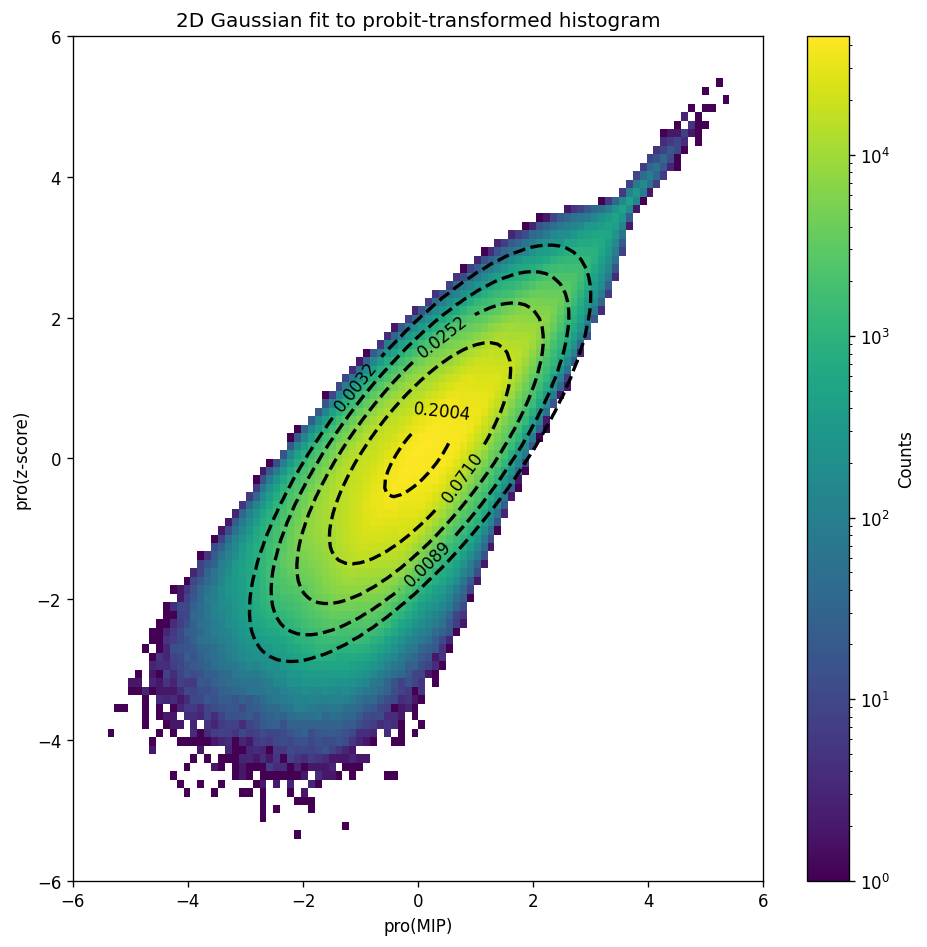

In [ ]:
# Plot the 2D Gaussian over the histogram
fig, ax = plt.subplots(figsize=(8, 8))
c = ax.imshow(
    hist_probit.T,
    origin="lower",
    extent=[xedges_probit[0], xedges_probit[-1], yedges_probit[0], yedges_probit[-1]],
    aspect="auto",
    cmap="viridis",
    norm=mpl.colors.LogNorm(),
)
cbar = fig.colorbar(c, ax=ax)
cbar.set_label("Counts")

z = norm_opt.pdf(np.dstack(np.meshgrid(x, y)).reshape(-1, 2))
z = z.reshape(hist_probit.shape)
levels = np.logspace(-0.698, -2.5, num=5, base=10)
cont = ax.contour(
    x,
    y,
    z,
    levels=levels[::-1],
    colors="black",
    linestyles="--",
    linewidths=2,
)
ax.clabel(cont, inline=True, fontsize=10, fmt="%.4f")
ax.set_title("2D Gaussian fit to probit-transformed histogram")
ax.set_xlabel("pro(MIP)")
ax.set_ylabel("pro(z-score)")
plt.tight_layout()
plt.show()